In [2]:
# qubit reset: Analysis of probability ['0'] vs number of resets:       
#This cell has function which can produce circuit of qubit reset, num_reset times
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister,transpile
from qiskit.circuit.classical import expr
def get_qubit_reset(num_resets):
    cr1=ClassicalRegister(1,name="cr1")     # for mid circuit measurement    
    qr=QuantumRegister(1,name="qr")
    qc=QuantumCircuit(qr,cr1)
    # initialization
    qc.h(0)    
    for i in range(num_resets):
        # mid Circuit Measurement
        qc.measure(qr[0],cr1[0])
        parity= expr.lift(cr1[0])
        #feed forward operation
        with qc.if_test(parity):
            qc.x(qr[0])
    qc.measure(qr[0],cr1[0])               # Final measurement
    return qc

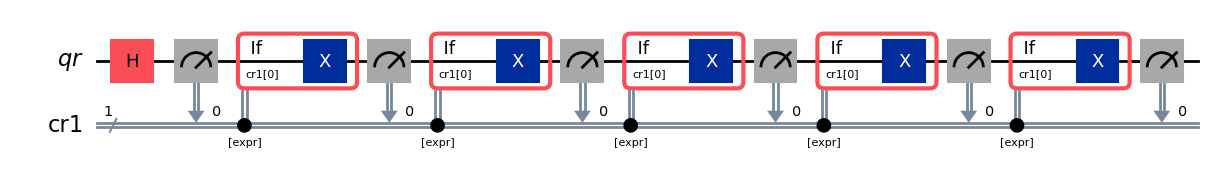

In [3]:
# This cell is for testing whether we succeded in previous cell
qc=get_qubit_reset(5)
qc.draw("mpl")

In [4]:
# trasnpilation
# Creating list of transpiled circuits having 1 no of resets to 10 no of resets (10 copies of each circuit)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
service=QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
pm=generate_preset_pass_manager(optimization_level=1,backend=backend)

max_num_reset=10
qc_transpiled_list=[]
num_reset_list=list(range(1,max_num_reset+1))
for num_reset in num_reset_list:
    for i in range(10):                     # for taking 10 copies of each circuit , needed for taking mean, standard deviation of the probability ['0']
        circuit=get_qubit_reset(num_reset)   # However, all 10 outputs will be same (seed is fixed)
        qc_transpiled=pm.run(circuit)
        qc_transpiled_list.append(qc_transpiled)

In [6]:
# Execution
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler=Sampler(backend=backend)
job=sampler.run(qc_transpiled_list)
print(job.job_id())

csen6e1tj7dg008cjwd0


In [14]:
# post processing
import matplotlib.pyplot as plt
import statistics
from qiskit_ibm_runtime import QiskitRuntimeService
job_id='csen6e1tj7dg008cjwd0'
service=QiskitRuntimeService()
job=service.job(job_id)
result=job.result()
list_std_deviation_prob_zero=[]
list_mean_prob_zero=[]
list_probs=[]                             # we will fill here our probabilities of zero corresponding to number of qubit resets 
for i in range(0,len(num_reset_list)):
    for j in range(10):
        data = result[10*i+j].data             
        counts=data.cr1.get_counts()
        total_counts=data.cr1.num_shots
        prob_zero=(counts['0'])/total_counts
        list_probs.append(prob_zero)
    list_mean_prob_zero.append(statistics.mean(list_probs))
    list_std_deviation_prob_zero.append(statistics.stdev(list_probs))
    list_probs.clear()                                           # for next iteration use
"""plt.plot(num_reset_list,list_mean_prob_zero,'--o',label='Mean Probability of zero in 10 samples')
plt.plot(num_reset_list,list_std_deviation_prob_zero,'-.^',label='std deviation of probabilities in 10 samples')
plt.xlabel('number of qubit resets')
plt.ylabel('probability, std deviation of outcome zero  ')
plt.legend()
"""

"plt.plot(num_reset_list,list_mean_prob_zero,'--o',label='Mean Probability of zero in 10 samples')\nplt.plot(num_reset_list,list_std_deviation_prob_zero,'-.^',label='std deviation of probabilities in 10 samples')\nplt.xlabel('number of qubit resets')\nplt.ylabel('probability, std deviation of outcome zero  ')\nplt.legend()\n"

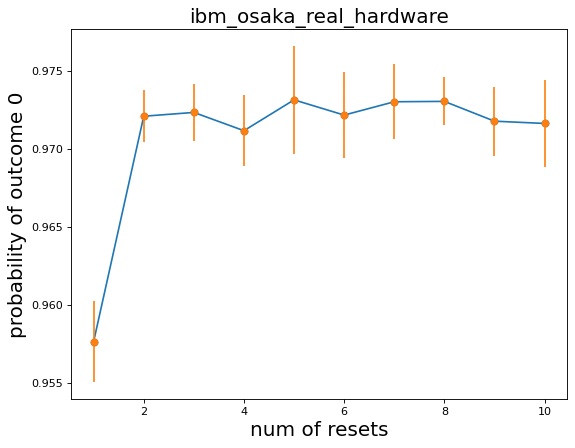

In [17]:
# Plotting Graph
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=80)
plt.xlabel('num of resets',fontsize=18)
plt.ylabel('probability of outcome 0',fontsize=18)
plt.title('ibm_osaka_real_hardware',fontsize=18)
x1 = num_reset_list
y1 = list_mean_prob_zero
y_error =list_std_deviation_prob_zero
plt.plot(x1, y1, 'o-')
plt.errorbar(x1, y1,
			yerr = y_error, 
			fmt ='o')
plt.show()

In [9]:
list_mean_prob_zero  # printing probability corresponding to different no of reset qubits operation (not expected this oscillation)

[0.9576416015625,
 0.9720947265625,
 0.9723388671875,
 0.9711669921875,
 0.97314453125,
 0.97216796875,
 0.9730224609375,
 0.973046875,
 0.97177734375,
 0.971630859375]

In [5]:
backend.target.operation_names             # way of checking whether dynamic circuit is allowed in a backend

dict_keys(['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'switch_case', 'if_else', 'for_loop', 'delay'])